## Imports

In [54]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/eli/projects/ner-german-telegram/src'))

In [55]:
import pandas as pd
import numpy as np
import torch
from datasets import load_from_disk
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_dataset, Dataset, load_metric, DatasetDict
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

## Model

In [56]:
model_name = 'dbmdz/bert-base-german-uncased'

## Dataset

In [57]:
dataset_name = 'smartdata'

## Tokenizer

In [58]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # more params defined in method tokenize_and_align_labels()

## Data collator

In [59]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Training params

In [60]:
NUM_EPOCHS = 10
BATCH_SIZE = 2
LOGGING_STRATEGY='epoch'
OUTPUT_DIR = f'../../../../../models/{model_name}-{dataset_name}-{NUM_EPOCHS}_epochs'
OVERWRITE_OUTPUT_DIR = True # only for first experiments
LOG_LEVEL = 'error'
EVALUATION_STRATEGY = 'epoch'
SAVE_STRATEGY ='epoch'
WEIGHT_DECAY = 0.01 # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
CALLBACK = EarlyStoppingCallback(early_stopping_patience=3)
LOAD_BEST_MODEL_AT_END = True,
METRIC_FOR_BEST_MODEL='eval_loss'

## Check GPU and set up torch device

In [61]:
# check gpu
torch.cuda.is_available()

True

In [62]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load dataset

In [63]:
ds = load_from_disk(f'/home/eli/data/data_prepared_for_tf/{dataset_name}/')

In [64]:
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str'],
        num_rows: 1861
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str'],
        num_rows: 230
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str'],
        num_rows: 228
    })
})

## Methods

In [65]:
def get_indices_and_tags(ds, split='train', tag_name='ner_tags'):
    tags = ds[split].features[tag_name].feature
    #id2label param for model
    index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
    # label2id param for model
    tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
    
    return tags, index2tag, tag2index


def ner_tags_str2id(ner_tags_str):
    
    tag_ids = []

    for tag in ner_tags_str:         
        idx = tag2index[tag]
        tag_ids.append(int(idx))
        
    return tag_ids


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove)

In [66]:
# Evaluation

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {'f1': f1, 
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_accuracy']]
    df = df.rename(columns={"epoch":"epoch",
                            "loss": "training_loss", 
                            "eval_loss": "validation_loss", 
                            "eval_f1":"f1", 
                            "eval_precision": "precision",
                           'eval_recall': 'recall', 
                            'eval_accuracy': 'accuracy'})
    df['epoch'] = df["epoch"].apply(lambda x: round(x))
    df['training_loss'] = df["training_loss"].ffill()
    df[['validation_loss', 'f1']] = df[['validation_loss', 'f1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [67]:
tags, index2tag, tag2index = get_indices_and_tags(ds)

In [68]:
ds_encoded = encode_dataset(ds)

Loading cached processed dataset at /home/eli/data/data_prepared_for_tf/smartdata/train/cache-1c80317fa3b1799d.arrow
Loading cached processed dataset at /home/eli/data/data_prepared_for_tf/smartdata/test/cache-bdd640fb06671ad1.arrow
Loading cached processed dataset at /home/eli/data/data_prepared_for_tf/smartdata/validation/cache-3eb13b9046685257.arrow


## model initialization and config

In [69]:
model_config = AutoConfig.from_pretrained(model_name, 
                                        num_labels=tags.num_classes, 
                                        id2label=index2tag,
                                        label2id=tag2index)

In [70]:
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config).to(device)

## Training

In [71]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, 
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR, 
    log_level=LOG_LEVEL, 
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE, 
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=LOGGING_STRATEGY,
    disable_tqdm=False,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL)

In [72]:
trainer = Trainer(
    model=model, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=ds_encoded['train'],
    eval_dataset=ds_encoded['test'],
    tokenizer=tokenizer,
    callbacks=[CALLBACK])

In [73]:
%time
trainer.train()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


/home/eli/envs/bt/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=5586, training_loss=0.18202897361047884, metrics={'train_runtime': 927.7327, 'train_samples_per_second': 20.06, 'train_steps_per_second': 10.035, 'total_flos': 2917929745926144.0, 'train_loss': 0.18202897361047884, 'epoch': 6.0})

In [74]:
trainer.evaluate()

{'eval_loss': 0.25601816177368164,
 'eval_f1': 0.6156225831399845,
 'eval_precision': 0.6312450436161776,
 'eval_recall': 0.600754716981132,
 'eval_accuracy': 0.9302879562810902,
 'eval_runtime': 2.3865,
 'eval_samples_per_second': 96.375,
 'eval_steps_per_second': 48.187,
 'epoch': 6.0}

In [75]:
eval_df = get_training_history(trainer)

In [76]:
eval_df

epoch  training_loss  validation_loss        f1  precision    recall  \
0       1         0.5127         0.301535  0.552436        NaN       NaN   
1       1         0.5127         0.301535  0.552436   0.609845  0.504906   
2       2         0.2634         0.258139  0.584983        NaN       NaN   
3       2         0.2634         0.258139  0.584983   0.579142  0.590943   
4       3         0.1499         0.256018  0.615623        NaN       NaN   
5       3         0.1499         0.256018  0.615623   0.631245  0.600755   
6       4         0.0852         0.299126  0.636193        NaN       NaN   
7       4         0.0852         0.299126  0.636193   0.631696  0.640755   
8       5         0.0503         0.331555  0.656097        NaN       NaN   
9       5         0.0503         0.331555  0.656097   0.656344  0.655849   
10      6         0.0307         0.347486  0.654518        NaN       NaN   
11      6         0.0307         0.347486  0.654518   0.658518  0.650566   
12      6         0.0307         0.256018  0.615623        NaN       NaN   
13      6         0.0307         0.256018  0.615623   0.631245  0.600755   

    accuracy  
0        NaN  
1   0.915365  
2        NaN  
3   0.920549  
4        NaN  
5   0.930288  
6        NaN  
7   0.931619  
8        NaN  
9   0.934912  
10       NaN  
11  0.934492  
12       NaN  
13  0.930288

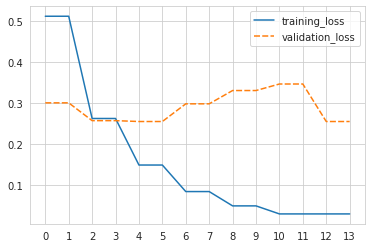

In [77]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['training_loss', 'validation_loss']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

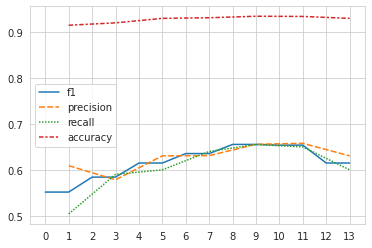

In [78]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['f1', 'precision', 'recall', 'accuracy']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

In [79]:
trainer.create_model_card()